<a href="https://colab.research.google.com/github/JairoMillapan/Tarea_4/blob/main/Copia_de_2023_2_UOH_COM4402_Tarea_4_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 4: Aprendizaje Profundo Avanzado**

### **Transferencia neuronal de estilos**

### Estudiante: Jairo Millapán

¿Alguna vez has deseado pintar como Picasso o Van Gogh?.

Esto se conoce como *transferencia neuronal de estilo* y la técnica se describe en <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.).

La transferencia neuronal de estilo es una técnica de optimización utilizada para tomar dos imágenes -una imagen de *contenido* y una imagen de *referencia de estilo* (como una obra de arte de un pintor famoso)- y mezclarlas para que la imagen de salida se parezca a la imagen de contenido, pero "pintada" con el estilo de la imagen de referencia de estilo.

Esto se consigue optimizando la imagen de salida para que coincida con las estadísticas de contenido de la imagen de contenido y las estadísticas de estilo de la imagen de referencia de estilo. Estas estadísticas se extraen de las imágenes mediante una red convolucional.

Por ejemplo, tomemos una imagen de este perro y la Composición 7 de Wassily Kandinsky:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>


<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Ahora bien, ¿qué aspecto tendría si Kandinsky decidiera pintar el cuadro de este Perro exclusivamente con este estilo? ¿Algo así?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Importar y configurar módulos

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Descargue imágenes y elija una imagen de estilo y otra de contenido:

In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 2us/step


## Visualizar la entrada

Defina una función para cargar una imagen y limitar su dimensión máxima a 512 píxeles.

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Crear una función simple para mostrar una imagen:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

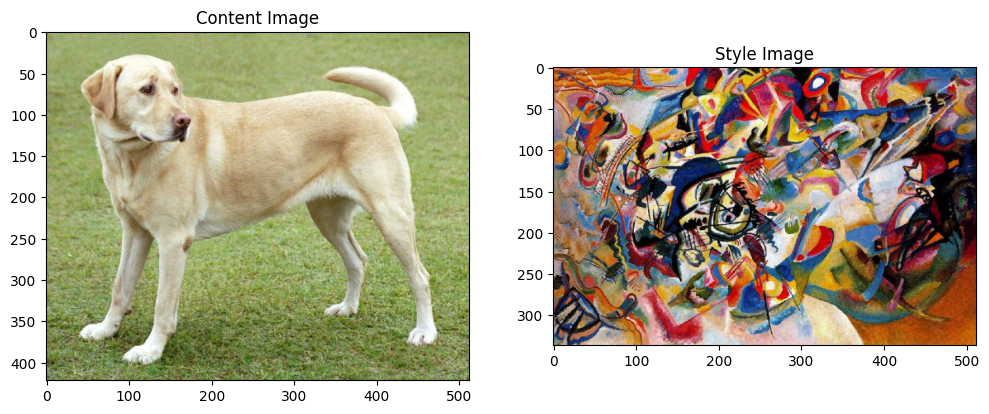

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Transferencia rápida de estilos usando TF-Hub

Este ejercicio demuestra el algoritmo original de transferencia de estilo, que optimiza el contenido de la imagen a un estilo particular. Antes de entrar en detalles, veamos cómo lo hace el [modelo TensorFlow Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2):

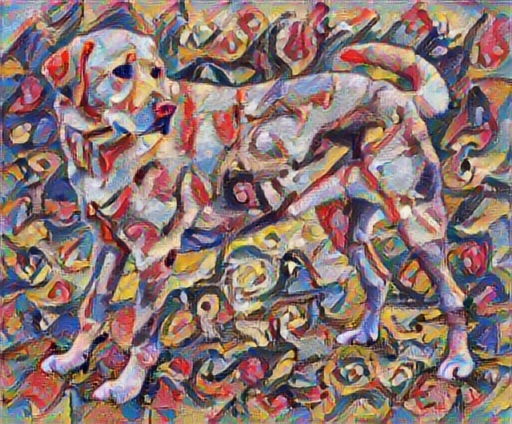

In [9]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Definir las representaciones de contenido y estilo

Utilice las capas intermedias del modelo para obtener las representaciones de *contenido* y *estilo* de la imagen. Empezando por la capa de entrada de la red, las activaciones de las primeras capas representan características de bajo nivel como bordes y texturas. A medida que se avanza por la red, las últimas capas representan características de nivel superior, partes de objetos como *ruedas* u *ojos*. En este caso, está utilizando la arquitectura de red VGG19, una red de clasificación de imágenes preentrenada. Estas capas intermedias son necesarias para definir la representación del contenido y el estilo a partir de las imágenes. Para una imagen de entrada, intente hacer coincidir las representaciones objetivo de estilo y contenido correspondientes en estas capas intermedias.

Cargue un [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) y pruébelo en nuestra imagen para asegurarse de que se utiliza correctamente:

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 26s 0us/step


TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('Labrador_retriever', 0.49317148),
 ('golden_retriever', 0.23665288),
 ('kuvasz', 0.036357507),
 ('Chesapeake_Bay_retriever', 0.02418274),
 ('Greater_Swiss_Mountain_dog', 0.01864608)]

Ahora cargue un `VGG19` sin los headers de clasificación, y liste los nombres de las capas

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 5s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Elija capas intermedias de la red para representar el estilo y el contenido de la imagen:

In [13]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Capas intermedias de estilo y contenido

¿Por qué estas salidas intermedias de nuestra red de clasificación de imágenes preentrenada nos permiten definir representaciones de estilo y contenido?

A un alto nivel, para que una red pueda realizar una clasificación de imágenes (para lo que ha sido entrenada esta red), debe comprender la imagen. Esto requiere tomar la imagen en bruto como píxeles de entrada y construir una representación interna que convierta los píxeles de la imagen en bruto en una comprensión compleja de las características presentes en la imagen.

Ésta es también una de las razones por las que las redes neuronales convolucionales son capaces de generalizar bien: son capaces de captar las invarianzas y las características definitorias dentro de las clases (por ejemplo, gatos frente a perros) que son agnósticas al ruido de fondo y otras molestias. Así, entre el momento en que la imagen en bruto se introduce en el modelo y la etiqueta de clasificación de salida, el modelo actúa como un complejo extractor de características. Al acceder a las capas intermedias del modelo, es capaz de describir el contenido y el estilo de las imágenes de entrada.

## Construir el modelo

Las redes en `tf.keras.applications` están diseñadas para que puedas extraer fácilmente los valores de las capas intermedias usando la API funcional de Keras.

Para definir un modelo usando la API funcional, especifica las entradas y salidas:

`model = Model(inputs, outputs)`

La siguiente función construye un modelo VGG19 que devuelve una lista de salidas de capas intermedias:

In [14]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Y para crear el modelo:

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



## Calcular estilo

El contenido de una imagen está representado por los valores de los mapas de características intermedios.

Resulta que el estilo de una imagen puede ser descrito por las medias y correlaciones entre los diferentes mapas de características. Calcule una matriz de Gram que incluya esta información tomando el producto exterior del vector de características por sí mismo en cada posición y promediando ese producto exterior en todas las posiciones. Esta matriz de Gram se puede calcular para una capa en particular como:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

Esto se puede implementar de forma concisa utilizando la función `tf.linalg.einsum`:

In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extraer estilo y contenido

Construye un modelo que devuelva los tensores de estilo y contenido.

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Cuando se invoca sobre una imagen, este modelo devuelve la matriz grama (estilo) de las `style_layers` y el contenido de las `content_layers`:

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


## Ejecutar el descenso de gradiente

Con este extractor de estilo y contenido, ahora puede implementar el algoritmo de transferencia de estilo. Para ello, calcule el error cuadrático medio de la salida de su imagen con respecto a cada objetivo y, a continuación, tome la suma ponderada de estas pérdidas.

Establezca sus valores objetivo de estilo y contenido:

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Defina una `tf.Variable` para contener la imagen a optimizar. Para hacerlo rápido, inicialícela con la imagen de contenido (la `tf.Variable` debe tener la misma forma que la imagen de contenido):

In [20]:
image = tf.Variable(content_image)

Como se trata de una imagen flotante, defina una función para mantener los valores de los píxeles entre 0 y 1:

In [21]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Cree un optimizador. El documento recomienda LBFGS, pero Adam también funciona bien:

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Para optimizarlo, utiliza una combinación ponderada de las dos pérdidas para obtener la pérdida total:

In [23]:
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Utilice `tf.GradientTape` para actualizar la imagen.

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Ahora ejecute algunos pasos para probar:

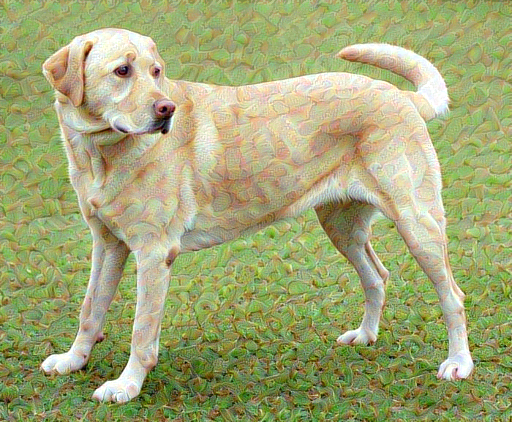

In [26]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Ya que funciona, realiza una optimización más larga:

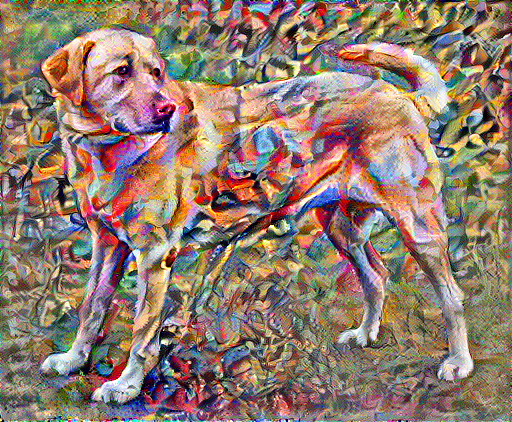

Train step: 1000
Total time: 75.7


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Pérdida total de variación

Una desventaja de esta implementación básica es que produce muchos artefactos de alta frecuencia. Redúzcalos utilizando un término de regularización explícito en los componentes de alta frecuencia de la imagen. En la transferencia de estilo, esto se denomina a menudo *pérdida de variación total*:

In [28]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

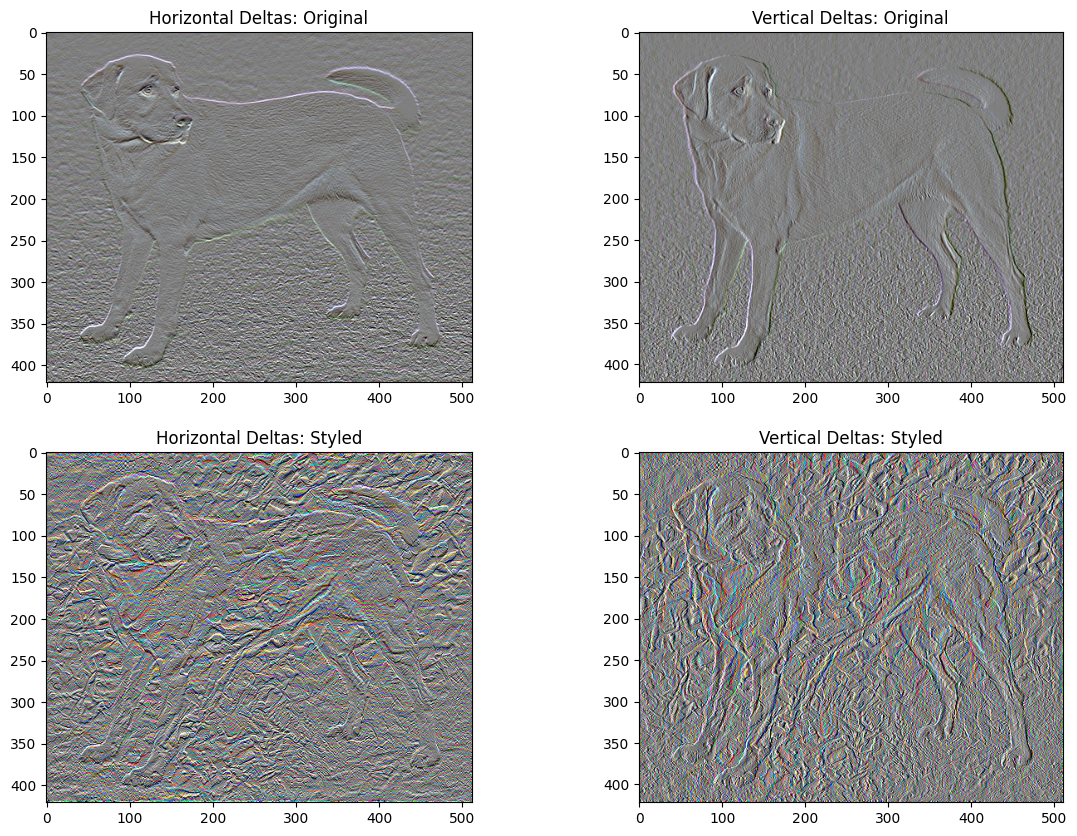

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Esto muestra cómo han aumentado los componentes de alta frecuencia.

Además, este componente de alta frecuencia es básicamente un detector de bordes. Se puede obtener un resultado similar del detector de bordes Sobel, por ejemplo:

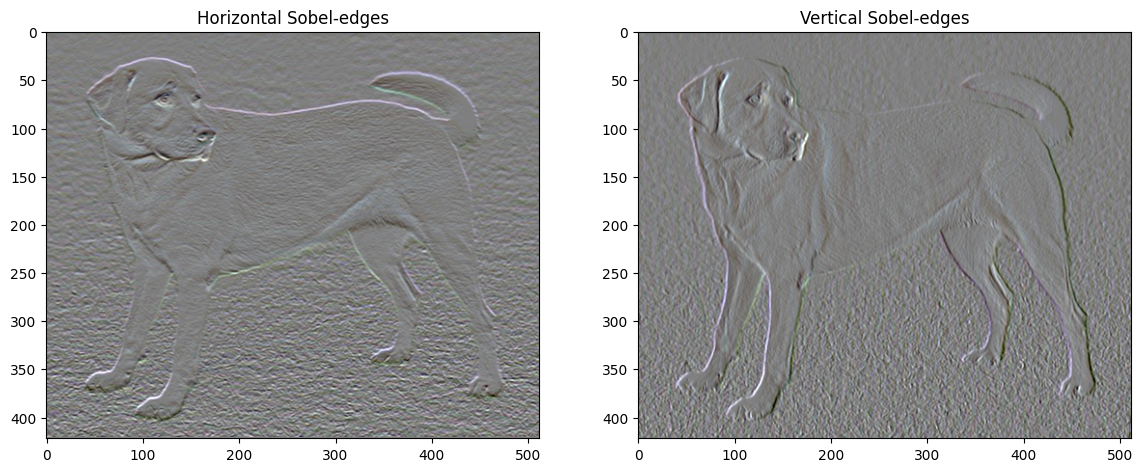

In [30]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

La pérdida de regularización asociada es la suma de los cuadrados de los valores:

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

149428.31

Eso demostró lo que hace. Pero no hay necesidad de implementarlo usted mismo, TensorFlow incluye una implementación estándar:

In [33]:
tf.image.total_variation(image).numpy()

array([149428.31], dtype=float32)

## Vuelva a ejecutar la optimización

Elija un peso para el `total_variation_loss`:

In [34]:
total_variation_weight=30

Ahora inclúyelo en la función `train_step`:

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinicie la variable de imagen y el optimizador:

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

Y ejecuta la optimización:

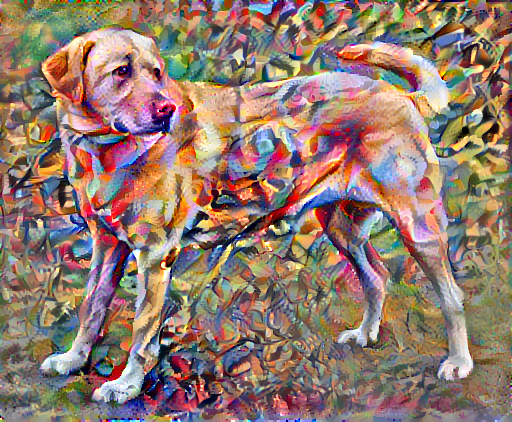

Train step: 1000
Total time: 79.7


In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Por último, guarda el resultado:

In [38]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>